In [1]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
import tensorflow as tf

In [58]:
#Importando dataset Acelerômetro
caminho = "SmartWatch/accel/"
arquivos = [arquivo for arquivo in os.listdir(caminho) if arquivo.endswith('.txt')]
accl = []
for i in arquivos:
  acc = pd.read_table(caminho+i, header=None, sep=",")
  accl.append(acc)
accel = pd.concat(accl, ignore_index=True)
accel.columns = ['pessoa', 'atividade', 'timestamp', 'x', 'y', 'z']
accel = accel.sort_values(by=['pessoa', 'atividade'])
accel = accel.reset_index(drop=True)
accel['z'] = accel['z'].replace(';', '', regex=True)
accel['z'] = accel['z'].str.strip()
accel['z'] = accel['z'].astype(float)

In [59]:
#Importando dataset Giroscópio
caminho = "SmartWatch/gyro/"
arquivos = [arquivo for arquivo in os.listdir(caminho) if arquivo.endswith('.txt')]
g = []
for i in arquivos:
  giro = pd.read_table(caminho+i, header=None, sep=",")
  g.append(giro)
giro = pd.concat(g, ignore_index=True)
giro.columns = ['pessoa', 'atividade', 'timestamp', 'x', 'y', 'z']
giro = giro.sort_values(by=['pessoa', 'atividade'])
giro = giro.reset_index(drop=True)
giro['z'] = giro['z'].replace(';', '', regex=True)
giro['z'] = giro['z'].str.strip()
giro['z'] = giro['z'].astype(float)

In [60]:

def aceleracao_total(x, y, z):
  t = (y**2 + x**2 + z**2)**0.5
  return t
def giro_total(x,y,z, x1, y1, z1):
  t = ((x**2)+(x1**2) - 2*x*x1*(np.sin(y)*np.sin(y1)*np.cos((z-z1))+np.cos(y)*np.cos(y1)))**0.5
  return t

In [62]:
def transacc(x):
  for j in range(0, 1200, 20):
    valor = 0;
    for i in range(0, 20, 1):
      valor = valor + aceleracao_total(x.iloc[j+i, 3], x.iloc[(j+i), 4], x.iloc[(j+i), 5])
    dadospa.append(valor)
    atividade.append(x.iloc[j+i, 1])

def transgiro(x):
  for j in range(0, 1200, 20):
    valor= 0;
    for i in range(0,19,1):
      valor = valor + giro_total(x.iloc[(j+i),3], x.iloc[(j+i),4], x.iloc[(j+i),5], x.iloc[(j+i+1),3], x.iloc[(j+i+1),4], x.iloc[(j+i+1),5])
    dadospg.append(valor)

In [63]:
dadospa = []
dadospg = []
atividade = []
for i in range(1200,len(giro), 1200):
  transacc(accel[(i-1200):i])
  transgiro(giro[(i-1200):i])

C:\Users\midiacom\AppData\Local\Temp\ipykernel_7176\2909828199.py:5: RuntimeWarning: invalid value encountered in double_scalars
  t = ((x**2)+(x1**2) - 2*x*x1*(np.sin(y)*np.sin(y1)*np.cos((z-z1))+np.cos(y)*np.cos(y1)))**0.5


In [ ]:
print(len(dadospa))
print(len(dadospg))
print(len(atividade))
print(171960/60)

171960
171960
171960
2866.0


In [ ]:
df = pd.DataFrame({'pessoa': np.repeat(np.arange(1, 2867), 60), 'tempo': np.tile(np.arange(1,61), 2866), 'atividade': atividade, 'acelerômetro': dadospa, 'giroscópio': dadospg})

In [ ]:
parc_data_train = 0.8
andando = df.loc[df['atividade'] == 'A']
split = int(len(andando)*parc_data_train)
train_andando = andando[:split]
teste_andando = andando[split:]
parado = df.loc[df['atividade'] == 'D']
split = int(len(parado)*parc_data_train)
train_parado = parado[:split]
teste_parado = parado[split:]
treino = pd.concat([train_andando, train_parado])
teste = pd.concat([teste_andando, teste_parado])
label = treino['atividade']
label = label.replace({'A': 0, 'D': 1})
treino = treino[['acelerômetro', 'giroscópio']].values

21.303119807324062

In [24]:
Npred = 2
Npontos = 60
#Pessoas 257
#Tempo de dados 60
#features 2

In [27]:
def cria_IN_OUT(data, janela, features):
    OUT_indices = np.arange(janela, len(data), janela)
    OUT = data[OUT_indices]
    IN = data[range(janela*len(OUT))]
    IN = np.reshape(IN, (len(OUT), janela, features))
    IN_final = IN[:,:-Npred,:]
    return IN_final
trainX = cria_IN_OUT(treino, Npontos, 2)
trainY = cria_IN_OUT(label, Npontos, 1)
print('trainX.shape= ',trainX.shape)
print('trainY.shape= ',trainY.shape)

trainX.shape=  (257, 58, 2)
trainY.shape=  (257, 58, 1)


In [37]:
def cria_LSTM(hidden_units, dense_units, input_shape, activation):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.LSTM(hidden_units, input_shape=input_shape,activation=activation[0], return_sequences=True))
  model.add(tf.keras.layers.Dense(units=dense_units, activation=activation[1]))
  model.compile(loss='mean_squared_error', optimizer = 'adam')
  return model

Epoch 1/5
257/257 [==============================] - 1s 4ms/step - loss: nan
Epoch 2/5
257/257 [==============================] - 1s 4ms/step - loss: nan
Epoch 3/5
257/257 [==============================] - 1s 4ms/step - loss: nan
Epoch 4/5
257/257 [==============================] - 1s 4ms/step - loss: nan
Epoch 5/5
257/257 [==============================] - 1s 4ms/step - loss: nan


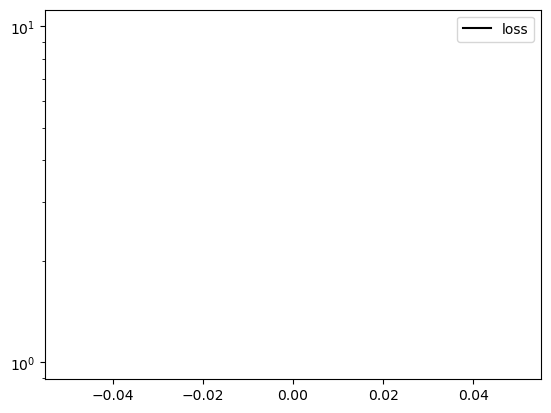

In [38]:
model = cria_LSTM(hidden_units=15, dense_units=1, input_shape=(58,2), activation=['relu', 'softmax'])
history = model.fit(trainX, trainY, epochs = 5, batch_size = 1, verbose = 1)
plt.figure()
plt.plot(history.history['loss'], 'k')
plt.yscale('log')
plt.legend(['loss'])

In [ ]:
trainX.shape

(257, 58, 2)

In [ ]:
trainX[0]

array([[209.9318519 ,  21.30311981],
       [236.92622194,  31.30303744],
       [253.33386419,  22.34932392],
       [261.15235504,  20.90198465],
       [251.23700941,  16.62793258],
       [270.83385877,  40.81177327],
       [274.14030852,  30.28345784],
       [269.33962288,  35.37033204],
       [275.74498536,  47.00274965],
       [253.01608968,  35.42401871],
       [254.26885817,  31.53510289],
       [271.32336999,  46.15698956],
       [266.86570303,  78.45061525],
       [258.45332376,  31.58953862],
       [262.053744  ,  51.18480045],
       [264.75444718,  56.13645815],
       [241.3095112 ,  21.49117987],
       [242.40024031,  33.38847681],
       [253.35628159,  49.58040106],
       [259.45656762,  28.28419103],
       [260.59331629,  32.99943281],
       [259.54199448,  27.93436066],
       [261.72751466,  53.24205455],
       [254.24062   ,  33.30887879],
       [248.35704068,  18.90402118],
       [238.07565044,  28.48787856],
       [252.23128342,  57.84191093],
 

In [ ]:
df

,pessoa,tempo,atividade,acelerômetro,giroscópio
0,1,1,A,209.931852,21.303120
1,1,2,A,236.926222,31.303037
2,1,3,A,253.333864,22.349324
3,1,4,A,261.152355,20.901985
4,1,5,A,251.237009,16.627933
...,...,...,...,...,...
19315,322,56,A,213.065583,0.099070
19316,322,57,A,213.725990,0.249282
19317,322,58,A,229.055799,0.103331
19318,322,59,A,277.806846,0.199670


In [ ]:
trainX[0]

array([[[2.09931852e+02, 2.13031198e+01],
        [2.36926222e+02, 3.13030374e+01],
        [2.53333864e+02, 2.23493239e+01],
        ...,
        [2.43784751e+02, 1.64520915e+01],
        [2.58591899e+02, 5.17204221e+01],
        [2.52467804e+02, 5.51230656e+01]],

       [[2.51710930e+02, 2.68770299e+01],
        [2.45590943e+02, 3.13560476e+01],
        [2.57390397e+02, 5.55247524e+01],
        ...,
        [2.48491848e+02, 1.93322104e+01],
        [2.50489313e+02, 1.99282614e+01],
        [2.55331327e+02, 1.79588161e+01]],

       [[2.51227953e+02, 2.29450394e+01],
        [2.51176354e+02, 5.52990122e+01],
        [2.55845223e+02, 4.31341860e+01],
        ...,
        [1.99105330e+02, 9.68676797e+00],
        [1.95889828e+02, 8.49268484e+00],
        [2.13053341e+02, 1.09944780e+01]],

       ...,

       [[1.89033940e+02, 1.76954439e+01],
        [1.89023506e+02, 2.07366215e+01],
        [1.89007076e+02, 2.10563470e+01],
        ...,
        [1.89149472e+02, 2.13987388e+01],
     